INSTALLING LIBRARIES

In [1]:
!pip install tensorflow pandas numpy scikit-learn nltk seaborn matplotlib

IMPORTING LIBRARIES

In [2]:
# Core Libraries
import pandas as pd
import numpy as np
import re
import html
import time
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Scikit-learn for classical ML and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# TensorFlow / Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)

True

LOAD AND SIMULATE DATA

In [3]:
df = pd.read_csv("IMDB Dataset.csv", engine='python')
df = df.sample(n=20000).reset_index(drop=True)
print(f"Loaded {len(df)} reviews.")
display(df.head())

Loaded 20000 reviews.


,review,sentiment
0,This was one of the DVD's I recently bought in...,positive
1,"Possibly one of the best, most horrible b movi...",negative
2,Ironically for a play unavailable on film or v...,positive
3,"I saw the movie ""Hoot"" and then I immediately ...",positive
4,I can't believe that people thought this stink...,negative


PREPROCESSING TEXT & PREPARING DATA

In [4]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_review_with_stopwords_and_stemming(review):
    review = html.unescape(review)
    review = re.sub(r'<.*?>', '', review)
    review = review.lower()
    review = re.sub(r'[^a-z\s]', '', review)
    words = review.split()
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]
    cleaned_review = ' '.join(cleaned_words)
    return cleaned_review

df['review_cleaned'] = df['review'].apply(clean_review_with_stopwords_and_stemming)

ENCODING

In [7]:
encoder = LabelEncoder()
df['sentiment_encoded'] = encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment,review_cleaned,sentiment_encoded
0,This was one of the DVD's I recently bought in...,1,one dvd recent bought set six call frenchfilm ...,1
1,"Possibly one of the best, most horrible b movi...",0,possibl one best horribl b movi ever bad rando...,0
2,Ironically for a play unavailable on film or v...,1,iron play unavail film video long arm man rema...,1
3,"I saw the movie ""Hoot"" and then I immediately ...",1,saw movi hoot immedi decid comment truth natur...,1
4,I can't believe that people thought this stink...,0,cant believ peopl thought stink heap trash fun...,0


Train-Test Split

In [8]:
RANDOM_STATE = 42
# We split the *cleaned* text for Keras and the *original* text for Tfidf
text_train, text_test, y_train, y_test = train_test_split(
    df['review_cleaned'], df['sentiment_encoded'],
    test_size=0.2, random_state=RANDOM_STATE
)
print(f"Training samples: {len(text_train)}, Test samples: {len(text_test)}")

Training samples: 16000, Test samples: 4000


TOKENIZING

In [70]:
# Keras Tokenization (for Neural Networks)

VOCAB_SIZE = 10000 # Limit to the top 10,000 words
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

X_train_seq = tokenizer.texts_to_sequences(text_train)
X_test_seq = tokenizer.texts_to_sequences(text_test)

MAXLEN = 200 # Pad all sequences to 200 words
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=MAXLEN)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=MAXLEN)

EMBEDDING_DIM = 100

Training Model 1: CNN

CNN Model Architecture

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model_cnn_overfit = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAXLEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
model_cnn_overfit.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

CNN Model Compilation & Training

In [29]:
# Compile the model
# Configure the model for training by specifying the optimizer, loss function, and metrics.
model_cnn_overfit.compile(
    optimizer='adam',  # Optimization algorithm (e.g., 'adam', 'sgd')
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Metrics to evaluate the model during training and testing
)

# Train the model
# Fit the model to the training data.
start_time_cnn_orig = time.time() # Record the start time for training
history_cnn_overfit = model_cnn_overfit.fit(
    X_train_pad,  # Training data (padded sequences)
    y_train,  # Training labels
    epochs=5,  # Number of training epochs (iterations over the entire dataset)
    batch_size=64,  # Number of samples per gradient update
    validation_data=(X_test_pad, y_test),  # Data for evaluation after each epoch
    verbose=0  # Set to 0 to suppress training output
)
train_time_cnn_orig = time.time() - start_time_cnn_orig # Calculate the training time

CNN Model Evaluation

--- 2. Original CNN Results ---
Train Time: 185.30s
F1-Score: 0.8557
Accuracy: 0.8555
              precision    recall  f1-score   support

           0     0.8468    0.8639    0.8553      1977
           1     0.8643    0.8473    0.8557      2023

    accuracy                         0.8555      4000
   macro avg     0.8556    0.8556    0.8555      4000
weighted avg     0.8557    0.8555    0.8555      4000



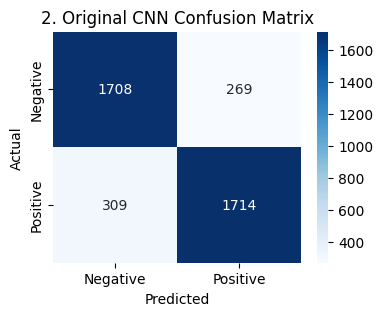

In [76]:
# Evaluate the trained CNN model
# Predict probabilities on the test set
y_pred_probs_cnn_orig = model_cnn_overfit.predict(X_test_pad, verbose=0)

# Convert probabilities to binary predictions (0 or 1)
y_pred_cnn_orig = (y_pred_probs_cnn_orig > 0.5).astype(int)

# Calculate F1-score and Accuracy
f1_cnn_orig = f1_score(y_test, y_pred_cnn_orig)
report_cnn_orig = classification_report(y_test, y_pred_cnn_orig, output_dict=True)
accuracy_cnn_orig = report_cnn_orig['accuracy']

# Print results
print(f"--- 2. Original CNN Results ---")
print(f"Train Time: {train_time_cnn_orig:.2f}s")
print(f"F1-Score: {f1_cnn_orig:.4f}")
print(f"Accuracy: {accuracy_cnn_orig:.4f}") # Print accuracy
print(classification_report(y_test, y_pred_cnn_orig, digits=4))

# Generate confusion matrix
cm_cnn_orig = confusion_matrix(y_test, y_pred_cnn_orig)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_cnn_orig, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('2. Original CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("original_cnn_cm.png") # Save the plot
plt.show()

# Update results dictionary including Accuracy
results['2. Original CNN'] = {'F1-Score': f1_cnn_orig, 'Train Time (s)': train_time_cnn_orig, 'Accuracy': accuracy_cnn_orig}

Plot Accuracy and Loss

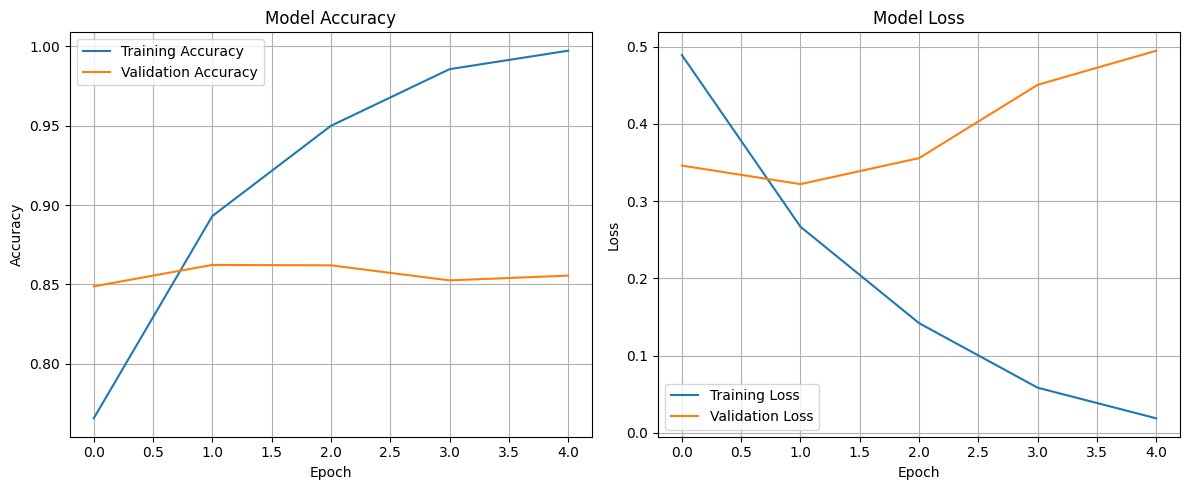

In [31]:
# Plot training and validation accuracy and loss

import matplotlib.pyplot as plt # Ensure matplotlib is imported

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axes[0].plot(history_cnn_overfit.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_cnn_overfit.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation loss
axes[1].plot(history_cnn_overfit.history['loss'], label='Training Loss')
axes[1].plot(history_cnn_overfit.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig("cnn_overfit_accuracy_loss.png")

# Display the plot
plt.show()

Training Model 2: Improved CNN (with Dropout)

In [41]:
# Improved CNN Model Architecture (with Dropout)
model_cnn_dropout = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAXLEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cnn_dropout.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

CNN Model Compilation and Training

In [42]:
# Improved CNN Model Compilation and Training

# Compile the model
# Configure the model for training by specifying the optimizer, loss function, and metrics.
model_cnn_dropout.compile(
    optimizer='adam',  # Optimization algorithm (e.g., 'adam', 'sgd')
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Metrics to evaluate the model during training and testing
)

# Train the model
# Fit the model to the training data.
start_time_cnn_dropout = time.time() # Record the start time for training
history_cnn_dropout = model_cnn_dropout.fit(
    X_train_pad,  # Training data (padded sequences)
    y_train,  # Training labels
    epochs=5,  # Number of training epochs (iterations over the entire dataset)
    batch_size=64,  # Number of samples per gradient update
    validation_data=(X_test_pad, y_test),  # Data for evaluation after each epoch
    verbose=0  # Set to 0 to suppress training output
)
train_time_cnn_dropout = time.time() - start_time_cnn_dropout # Calculate the training time

CNN Model Evaluation

--- 3. Improved CNN Results ---
Train Time: 235.78s
F1-Score: 0.8516
Accuracy: 0.8520
              precision    recall  f1-score   support

           0     0.8406    0.8644    0.8524      1977
           1     0.8638    0.8398    0.8516      2023

    accuracy                         0.8520      4000
   macro avg     0.8522    0.8521    0.8520      4000
weighted avg     0.8523    0.8520    0.8520      4000



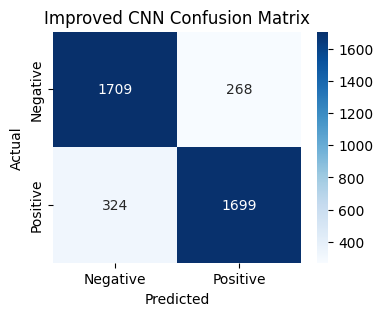

In [77]:
# Improved CNN Model Evaluation

# Predict probabilities on the test set
y_pred_probs_cnn_dropout = model_cnn_dropout.predict(X_test_pad, verbose=0)

# Convert probabilities to binary predictions (0 or 1)
y_pred_cnn_dropout = (y_pred_probs_cnn_dropout > 0.5).astype(int)

# Calculate F1-score and Accuracy
f1_cnn_dropout = f1_score(y_test, y_pred_cnn_dropout)
report_cnn_dropout = classification_report(y_test, y_pred_cnn_dropout, output_dict=True)
accuracy_cnn_dropout = report_cnn_dropout['accuracy']

# Print results
print(f"--- 3. Improved CNN Results ---")
print(f"Train Time: {train_time_cnn_dropout:.2f}s")
print(f"F1-Score: {f1_cnn_dropout:.4f}")
print(f"Accuracy: {accuracy_cnn_dropout:.4f}") # Print accuracy
print(classification_report(y_test, y_pred_cnn_dropout, digits=4))

# Generate confusion matrix
cm_cnn_dropout = confusion_matrix(y_test, y_pred_cnn_dropout)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_cnn_dropout, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Improved CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("improved_cnn_cm.png") # Save the plot
plt.show()

# Update results dictionary including Accuracy
results['3. Improved CNN'] = {'F1-Score': f1_cnn_dropout, 'Train Time (s)': train_time_cnn_dropout, 'Accuracy': accuracy_cnn_dropout}

Plot Accuracy and Loss

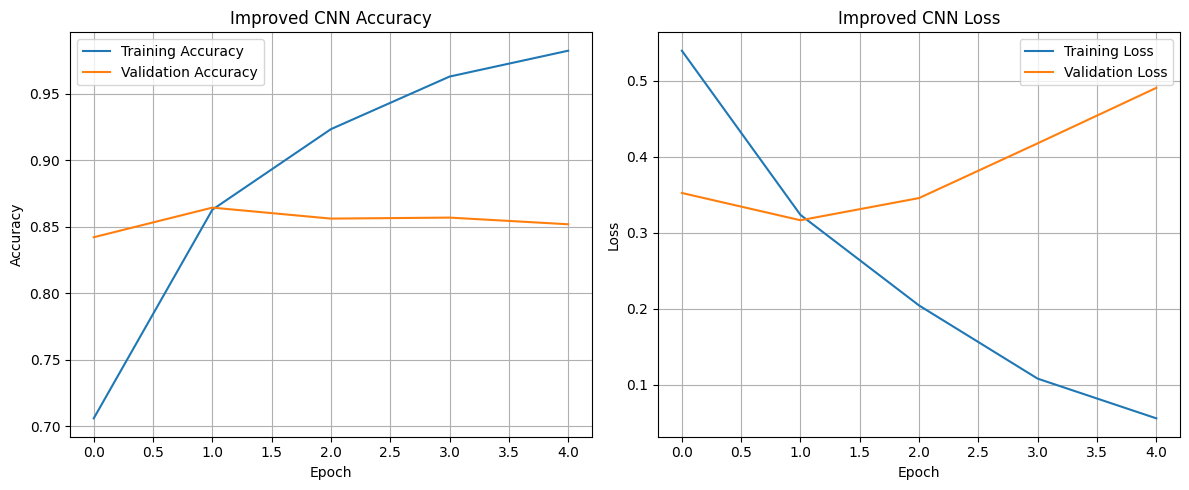

In [44]:
# Improved CNN Accuracy and Loss

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axes[0].plot(history_cnn_dropout.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_cnn_dropout.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Improved CNN Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation loss
axes[1].plot(history_cnn_dropout.history['loss'], label='Training Loss')
axes[1].plot(history_cnn_dropout.history['val_loss'], label='Validation Loss')
axes[1].set_title('Improved CNN Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig("improved_cnn_accuracy_loss.png")

# Display the plot
plt.show()

In [45]:
# Verify that the results dictionary is updated correctly for the Improved CNN model.
print("Results dictionary entry for '3. Improved CNN':")
display(results.get('3. Improved CNN'))

# Check if the F1-Score matches
calculated_f1 = f1_cnn_dropout
stored_f1 = results.get('3. Improved CNN', {}).get('F1-Score')

print(f"\nCalculated F1-Score: {calculated_f1:.4f}")
print(f"Stored F1-Score: {stored_f1:.4f}")
print(f"F1-Score Match: {abs(calculated_f1 - stored_f1) < 1e-9}")

# Check if the Train Time matches
calculated_train_time = train_time_cnn_dropout
stored_train_time = results.get('3. Improved CNN', {}).get('Train Time (s)')

print(f"\nCalculated Train Time: {calculated_train_time:.2f}s")
print(f"Stored Train Time: {stored_train_time:.2f}s")
print(f"Train Time Match: {abs(calculated_train_time - stored_train_time) < 1e-9}")

Results dictionary entry for '3. Improved CNN':


{'F1-Score': 0.8516290726817043, 'Train Time (s)': 235.78281044960022}


Calculated F1-Score: 0.8516
Stored F1-Score: 0.8516
F1-Score Match: True

Calculated Train Time: 235.78s
Stored Train Time: 235.78s
Train Time Match: True


Training Model 3: Bidirectional LSTM

In [55]:
# Define the Bidirectional LSTM model
model_lstm = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAXLEN),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model Compilation and Training

In [56]:
# Compile the model
# This step configures the model for training by specifying the optimizer, loss function, and metrics.
model_lstm.compile(
    optimizer='adam',  # Optimization algorithm: 'adam' is a popular choice known for its efficiency.
    loss='binary_crossentropy',  # Loss function: Suitable for binary classification problems.
    metrics=['accuracy']  # Metric: Tracks the proportion of correctly classified samples during training and evaluation.
)

# Train the model
# This step fits the model to the training data, adjusting its weights to minimize the loss function.
start_time_lstm = time.time() # Record the start time for training
history_lstm = model_lstm.fit(
    X_train_pad,  # Training data: Padded sequences of word indices.
    y_train,  # Training labels: The true sentiment (0 or 1) for each review.
    epochs=5,  # Number of epochs: The number of times the model will iterate over the entire training dataset.
    batch_size=64,  # Batch size: The number of samples per gradient update.
    validation_data=(X_test_pad, y_test),  # Validation data: Used to evaluate the model's performance after each epoch and detect overfitting.
    verbose=0  # Verbosity mode: Set to 0 to suppress training output for a cleaner notebook.
)
train_time_lstm = time.time() - start_time_lstm # Calculate the training time

Model Evaluation

--- 4. Bidirectional LSTM Results ---
Train Time: 594.61s
F1-Score: 0.8556
Accuracy: 0.8570
              precision    recall  f1-score   support

           0     0.8409    0.8766    0.8583      1977
           1     0.8742    0.8379    0.8556      2023

    accuracy                         0.8570      4000
   macro avg     0.8575    0.8572    0.8570      4000
weighted avg     0.8577    0.8570    0.8570      4000



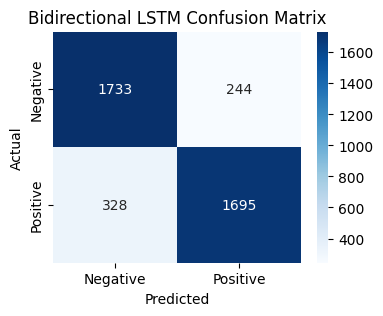

In [78]:
# Evaluate the trained Bidirectional LSTM model

# Predict probabilities on the test set
y_pred_probs_lstm = model_lstm.predict(X_test_pad, verbose=0)

# Convert probabilities to binary predictions (0 or 1)
y_pred_lstm = (y_pred_probs_lstm > 0.5).astype(int)

# Calculate F1-score and Accuracy
f1_lstm = f1_score(y_test, y_pred_lstm)
report_lstm = classification_report(y_test, y_pred_lstm, output_dict=True)
accuracy_lstm = report_lstm['accuracy']


# Print results
print(f"--- 4. Bidirectional LSTM Results ---")
print(f"Train Time: {train_time_lstm:.2f}s")
print(f"F1-Score: {f1_lstm:.4f}")
print(f"Accuracy: {accuracy_lstm:.4f}") # Print accuracy
print(classification_report(y_test, y_pred_lstm, digits=4))

# Generate confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Bidirectional LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("bidirectional_lstm_cm.png") # Save the plot
plt.show()

# Update results dictionary including Accuracy
results['4. Bidirectional LSTM'] = {'F1-Score': f1_lstm, 'Train Time (s)': train_time_lstm, 'Accuracy': accuracy_lstm}

Plot Accuracy and Loss

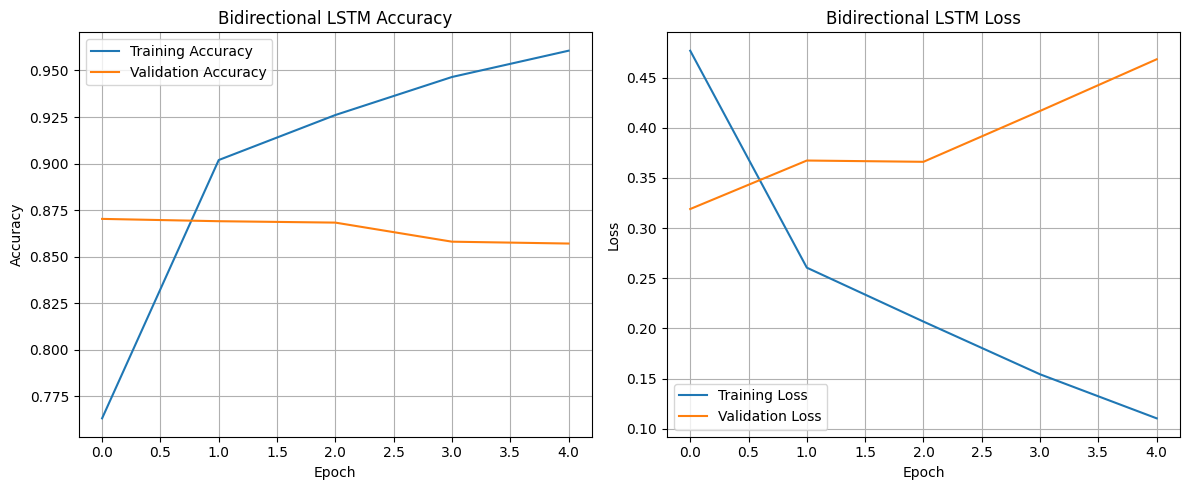

In [58]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axes[0].plot(history_lstm.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Bidirectional LSTM Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation loss
axes[1].plot(history_lstm.history['loss'], label='Training Loss')
axes[1].plot(history_lstm.history['val_loss'], label='Validation Loss')
axes[1].set_title('Bidirectional LSTM Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig("bidirectional_lstm_accuracy_loss.png")

# Display the plot
plt.show()

In [59]:
# Verify that the results dictionary is updated correctly for the Bidirectional LSTM model.
print("Results dictionary entry for '4. Bidirectional LSTM':")
display(results.get('4. Bidirectional LSTM'))

# Check if the F1-Score matches
calculated_f1 = f1_lstm
stored_f1 = results.get('4. Bidirectional LSTM', {}).get('F1-Score')

print(f"\nCalculated F1-Score: {calculated_f1:.4f}")
print(f"Stored F1-Score: {stored_f1:.4f}")
print(f"F1-Score Match: {abs(calculated_f1 - stored_f1) < 1e-9}")

# Check if the Train Time matches
calculated_train_time = train_time_lstm
stored_train_time = results.get('4. Bidirectional LSTM', {}).get('Train Time (s)')

print(f"\nCalculated Train Time: {calculated_train_time:.2f}s")
print(f"Stored Train Time: {stored_train_time:.2f}s")
print(f"Train Time Match: {abs(calculated_train_time - stored_train_time) < 1e-9}")

Results dictionary entry for '4. Bidirectional LSTM':


{'F1-Score': 0.8556284704694599, 'Train Time (s)': 594.61412358284}


Calculated F1-Score: 0.8556
Stored F1-Score: 0.8556
F1-Score Match: True

Calculated Train Time: 594.61s
Stored Train Time: 594.61s
Train Time Match: True


COMPARISON BETWEEN MODELS

/tmp/ipython-input-1669407208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_ordered_filtered, x='F1-Score', y='Model', palette='viridis')


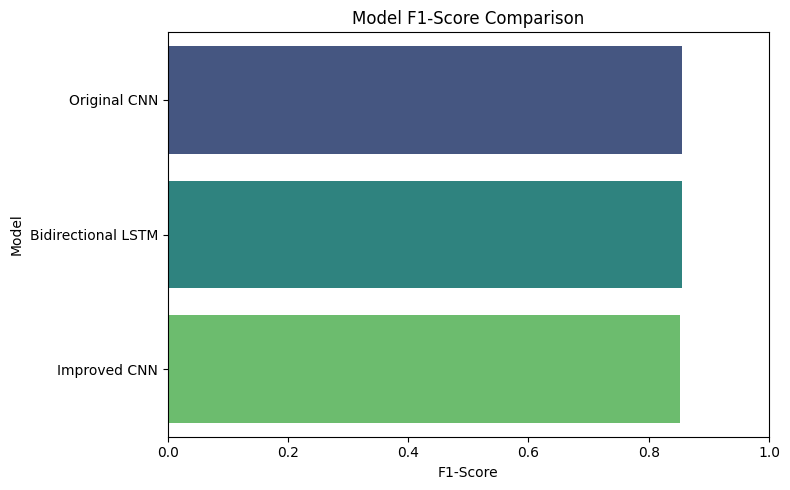

In [96]:
# Filter out the Tfidf LogRegression model for this plot
results_df_ordered_filtered = results_df_ordered[results_df_ordered['Model'] != 'Tfidf LogRegression']

# Plot F1-Score
plt.figure(figsize=(8, 5)) # Adjust figure size for a single plot
sns.barplot(data=results_df_ordered_filtered, x='F1-Score', y='Model', palette='viridis')
plt.title('Model F1-Score Comparison')
plt.xlabel('F1-Score')
plt.ylabel('Model')
plt.xlim(0, 1.0)
plt.tick_params(axis='y', labelsize=10)
plt.tight_layout() # Adjust layout
plt.savefig("f1_score_comparison_no_tfidf.png") # Save with a new filename
plt.show()

/tmp/ipython-input-1721756270.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_ordered_filtered, x='Train Time (s)', y='Model', palette='plasma', ax=ax)


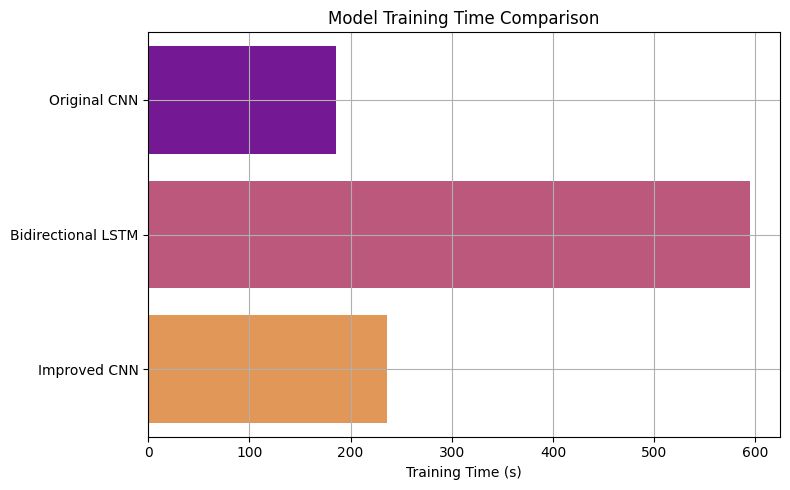

In [98]:
# Filter out the Tfidf LogRegression model for this plot
results_df_ordered_filtered = results_df_ordered[results_df_ordered['Model'] != 'Tfidf LogRegression']

# Create a figure and axes for the Training Time plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot Training Time
sns.barplot(data=results_df_ordered_filtered, x='Train Time (s)', y='Model', palette='plasma', ax=ax)
ax.set_title('Model Training Time Comparison')
ax.set_xlabel('Training Time (s)')
ax.set_ylabel('') # Remove y-label for the second plot to avoid overlap
ax.tick_params(axis='y', labelsize=10) # Adjust label size for readability
ax.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig("training_time_comparison.png")

# Display the plot
plt.show()

/tmp/ipython-input-734932050.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_ordered_filtered, x='Accuracy', y='Model', palette='viridis', ax=ax)


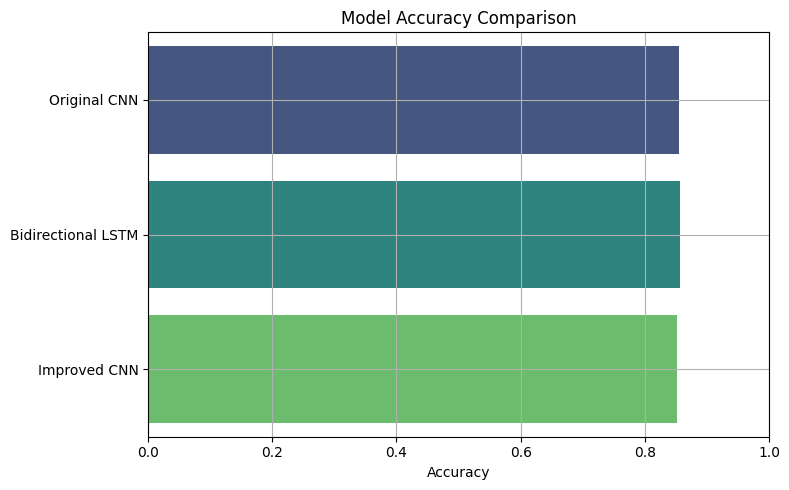

In [99]:
# Filter out the Tfidf LogRegression model for this plot
results_df_ordered_filtered = results_df_ordered[results_df_ordered['Model'] != 'Tfidf LogRegression']

# Create a figure and axes for the Accuracy plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot Accuracy
sns.barplot(data=results_df_ordered_filtered, x='Accuracy', y='Model', palette='viridis', ax=ax)
ax.set_title('Model Accuracy Comparison')
ax.set_xlim(0, 1.0)
ax.set_xlabel('Accuracy')
ax.set_ylabel('') # Remove y-label
ax.tick_params(axis='y', labelsize=10) # Adjust label size for readability
ax.grid(True)

# Ensure a tight layout
plt.tight_layout()

# Save the plot
plt.savefig("accuracy_comparison.png")

# Display the plot
plt.show()

In [103]:
# Filter out the Tfidf LogRegression model for this output
results_df_ordered_filtered = results_df_ordered[results_df_ordered['Model'] != 'Tfidf LogRegression']

print("--- Model Comparison Results ---")
print(results_df_ordered_filtered.to_markdown(index=False))

# Determine and print the best model based on Accuracy (handling potential NaN in other columns)
# Ensure results_df_ordered_filtered is sorted by Accuracy descending
results_df_ordered_filtered = results_df_ordered_filtered.sort_values(by='Accuracy', ascending=False)
best_model = results_df_ordered_filtered.iloc[0]
print(f"\n--- Best Performing Model (based on Accuracy)")
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
# Print F1-Score if available, otherwise indicate it's not available
if pd.notna(best_model['F1-Score']):
    print(f"F1-Score: {best_model['F1-Score']:.4f}")
else:
    print("F1-Score: Not available")
print(f"Train Time: {best_model['Train Time (s)']:.2f}s")

--- Model Comparison Results ---
| Model              |   F1-Score |   Train Time (s) |   Accuracy |
|:-------------------|-----------:|-----------------:|-----------:|
| Original CNN       |   0.855716 |          185.301 |     0.8555 |
| Bidirectional LSTM |   0.855628 |          594.614 |     0.857  |
| Improved CNN       |   0.851629 |          235.783 |     0.852  |

--- Best Performing Model (based on Accuracy)
Model: Bidirectional LSTM
Accuracy: 0.8570
F1-Score: 0.8556
Train Time: 594.61s


 Sentiment Prediction Script using the Best Model (Bidirectional LSTM)

In [114]:
# Define a function to preprocess new text data
def preprocess_new_text(text, tokenizer, maxlen, stop_words, stemmer):
    """
    Cleans and prepares new text data for prediction using the trained tokenizer and padding.
    """
    # Apply the same cleaning steps as used for the training data
    review = html.unescape(text)
    review = re.sub(r'<.*?>', '', review)
    review = review.lower()
    review = re.sub(r'[^a-z\s]', '', review)
    words = review.split()
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]
    cleaned_review = ' '.join(cleaned_words)

    # Convert text to sequences using the trained tokenizer
    seq = tokenizer.texts_to_sequences([cleaned_review])

    # Pad the sequences to the same length as the training data
    padded_seq = pad_sequences(seq, padding='post', maxlen=maxlen)

    return padded_seq

# Example usage:
# Assuming 'model_lstm', 'tokenizer', 'MAXLEN', 'stop_words', and 'stemmer' are already defined
# from the previous steps in the notebook.

# Get input from the user
new_review = input("Enter a movie review to predict its sentiment: ")

# Preprocess the new review
processed_review = preprocess_new_text(new_review, tokenizer, MAXLEN, stop_words, stemmer)

# Make a prediction using the trained Bidirectional LSTM model
prediction = model_lstm.predict(processed_review, verbose=0) # Added verbose=0 to hide 1/1 step

# The model outputs a probability (between 0 and 1)
# Convert the probability to a binary prediction (0 or 1)
predicted_sentiment_encoded = (prediction > 0.5).astype(int)[0][0]

# Decode the 0 or 1 manually.
if predicted_sentiment_encoded == 1:
    predicted_sentiment_label = "Positive"
else:
    predicted_sentiment_label = "Negative"

print(f"\nOriginal Review: {new_review}")
# Print the decoded label
print(predicted_sentiment_label)

Enter a movie review to predict its sentiment: what a fantastic movie, great direction

Original Review: what a fantastic movie, great direction
Positive


Save the Model

In [116]:
# Save the best performing model (Bidirectional LSTM)

# Define the file path for saving the model with the recommended .keras extension
model_save_path = "bidirectional_lstm_sentiment_model.keras"

# Save the model in the native Keras format
model_lstm.save(model_save_path)

print(f"Model saved successfully to: {model_save_path}")

# You can also save the tokenizer and label encoder if you need to load them later for predictions
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved successfully to: tokenizer.pkl")

with open('encoder.pkl', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Label encoder saved successfully to: encoder.pkl")

Model saved successfully to: bidirectional_lstm_sentiment_model.keras
Tokenizer saved successfully to: tokenizer.pkl
Label encoder saved successfully to: encoder.pkl
